<a href="https://colab.research.google.com/github/angelamejia804/TimeSeries/blob/main/Recepcion_Sarimax_3_2021_2022_Exogen_Var.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import pylab as pl
import warnings
import itertools
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
from matplotlib.colors import Normalize
from time import time
import os
import datetime
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()


mpl.rcParams['figure.figsize'] = (11, 4)
mpl.rcParams['axes.grid'] = False

import statsmodels.api as sm

plt.style.use('fivethirtyeight')

BASE DE DATOS DE RECEPCIÓN

Cargamos el archivo que se dejo preparado en el notebook
https://github.com/angelamejia804/TimeSeries/blob/main/Preparacion_TimeSeries_Recepcion_2_1.ipynb



In [3]:
from google.colab import files
uploaded = files.upload()

Saving df_recepcion_traint.csv to df_recepcion_traint.csv


In [4]:
df_r = pd.read_csv("df_recepcion_traint.csv", delimiter=';')

probemos con variables exogenas

In [5]:
from google.colab import files
uploaded = files.upload()

Saving df_gd_t.csv to df_gd_t.csv


In [6]:
GD = pd.read_csv("df_gd_t.csv", delimiter=';')

In [7]:
GD

,Unnamed: 0,Semana,mean,std,min,25%,50%,75%,max,Grados_dia,temporada
0,0,2020-W01,9.783494,0.247887,9.61,9.628154,9.628154,9.850,10.29,68.484461,False
1,1,2020-W02,10.098571,0.636014,9.33,9.535000,10.260000,10.545,10.94,70.690000,False
2,2,2020-W03,11.054286,0.668801,10.25,10.505000,11.050000,11.610,11.85,77.380000,True
3,3,2020-W04,10.660000,0.848999,9.41,10.300000,10.540000,11.115,11.84,74.620000,True
4,4,2020-W05,9.631429,0.864551,8.08,9.290000,9.860000,10.060,10.78,67.420000,True
...,...,...,...,...,...,...,...,...,...,...,...
152,152,2022-W48,9.870000,0.430310,9.21,9.610000,9.790000,10.265,10.34,69.090000,False
153,153,2022-W49,9.345714,0.507243,8.71,8.995000,9.320000,9.625,10.15,65.420000,False
154,154,2022-W50,8.977143,0.416122,8.35,8.730000,9.020000,9.230,9.55,62.840000,False
155,155,2022-W51,9.565714,0.484591,8.95,9.225000,9.500000,9.945,10.17,66.960000,False


In [8]:
df_r['Semana'] = df_r['Semana'].apply(str)  #fecha = pd.to_datetime(semana_str + '1', format='%Y%U%w')
#df['fecha'] = df['semana'].apply(lambda x: pd.to_datetime(x + '1', format='%Y%U%w'))

In [9]:
GD['Semana'] = GD['Semana'].apply(str)  #fecha = pd.to_datetime(semana_str + '1', format='%Y%U%w')

In [ ]:
df_r

,Semana,Tallos
0,2020-W01,91939
1,2020-W02,200892
2,2020-W03,676003
3,2020-W04,1288302
4,2020-W05,507192
...,...,...
151,2022-W48,311432
152,2022-W49,270706
153,2022-W50,257158
154,2022-W51,280126


In [ ]:
df_r.describe(include='all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Semana,156,156,2020-W01,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Tallos,156.0,NaN,NaN,NaN,282305.275641,178650.036641,72136.0,176563.5,237865.0,306604.75,1288302.0


In [ ]:
df_r.head()

,Semana,Tallos
0,2020-W01,91939
1,2020-W02,200892
2,2020-W03,676003
3,2020-W04,1288302
4,2020-W05,507192


Creamos un indice por semana que va ser usada como columna de agrupación y analisis, ademas se unira a los demas DF por este mismo atributo

In [10]:
df_recepcion = df_r.set_index('Semana')

In [ ]:
df_recepcion = df_recepcion['2020-W01':]

In [ ]:
df_recepcion=df_recepcion.groupby('Semana').sum() # promedio semanal

In [ ]:
df_recepcion_=df_recepcion.loc['2020-W01':] #desde el df original para el rango de tiempo seleccionado

In [11]:
df_recepcion_prueba=df_recepcion_.loc['2020-W01':'2021-W53'] #desde el df original para el rango de tiempo seleccionado
df_recepcion_prueba.head()

NameError: ignored

In [ ]:
df_recepcion_test=df_recepcion.loc['2022-W01':'2022-W53'] #dejamos el 2023 para probar el modelo
df_recepcion_test.head()

,Tallos
Semana,
2022-W01,208288
2022-W02,447260
2022-W03,772645
2022-W04,809965
2022-W05,504756


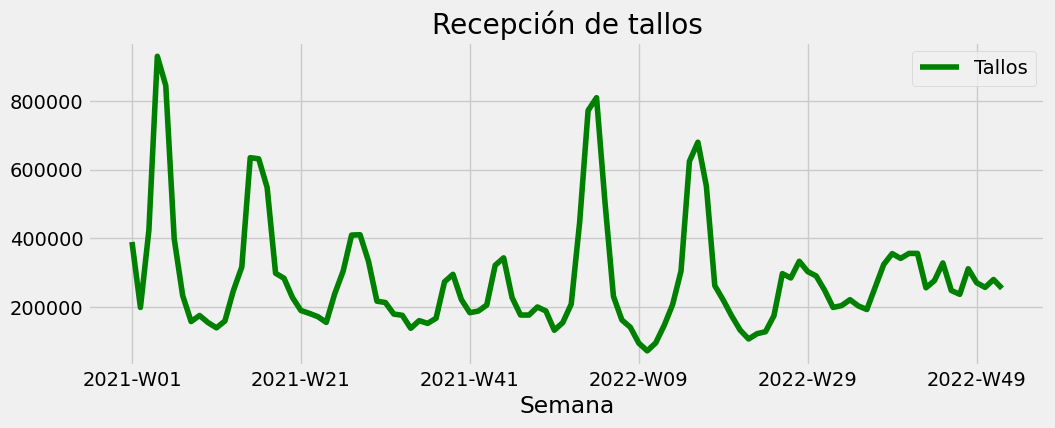

In [ ]:
df_recepcion_.plot(kind='line',y='Tallos',color='green')
plt.title("Recepción de tallos")
plt.show()


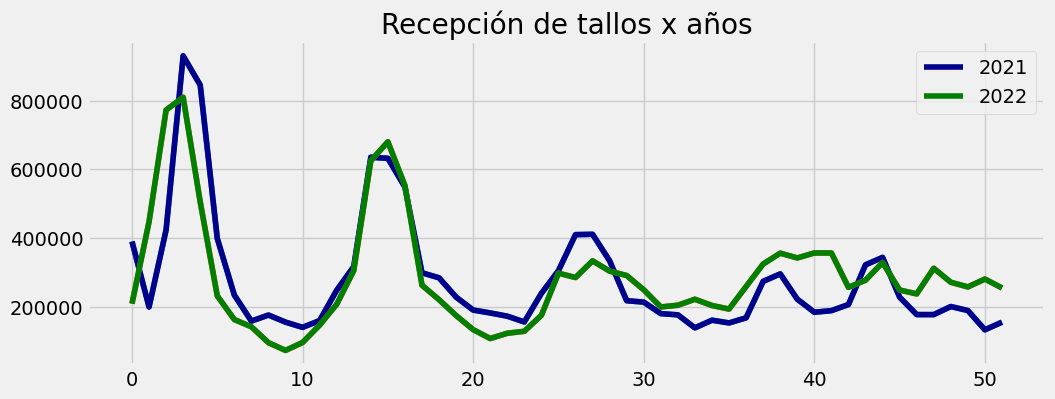

In [ ]:
df_rec_2021 = df_recepcion.loc['2021-W01':'2021-W53']
plt.plot(df_rec_2021.values)
plt.plot(df_rec_2021.values, color='darkblue',label='2021' )


df_rec_2022 = df_recepcion.loc['2022-W01':'2022-W53']
plt.plot(df_rec_2022.values)
plt.plot(df_rec_2022.values, color='green' ,label='2022')

#df_rec_2023 = df_recepcion.loc['2023-W01':'2023-W53']
#plt.plot(df_rec_2023.values)
#plt.plot(df_rec_2023.values, color='salmon',label='2023')

plt.title("Recepción de tallos x años")
plt.legend()

--------------------- ----------------------- ---------------------              ----------------------------------------- ---------

SARIMAX

Los modelos autorregresivos operan bajo la premisa de que los valores pasados tienen un efecto sobre los valores actuales. Los modelos AR se usan comúnmente para analizar la naturaleza, la economía y otros procesos que varían en el tiempo. Mientras se mantenga la suposición, podemos construir un modelo de regresión lineal que intente predecir el valor de una variable dependiente hoy, dados los valores que tenía en días anteriores.

https://towardsdatascience.com/machine-learning-part-19-time-series-and-autoregressive-integrated-movingc-average-model-arima-c1005347b0d7


 SARIMAX incluye un modelo exógeno que ARIMA no tiene. SARIMAX es más adecuado para modelos de series de tiempo que incluyen variables externas y tiene en cuenta la estacionalidad de los datos. ARIMA se utiliza principalmente para el análisis de la tendencia y la estacionalidad de los datos de la serie temporal.

In [ ]:
#recepcion = df_recepcion.loc['202001':'202253'] #unicamente los años competos

Probamos definiendo los parametros a traves del calculo AIC, con el DF completo (2020- 2022)

In [12]:
y=df_recepcion

In [13]:
y # los datos de la serie comppleta 2020-2022

,Tallos
Semana,
2020-W01,91939
2020-W02,200892
2020-W03,676003
2020-W04,1288302
2020-W05,507192
...,...
2022-W48,311432
2022-W49,270706
2022-W50,257158


Definición deparametros de Sarimax con criterio AIC

In [ ]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

In [ ]:
# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

In [ ]:
# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p, d, q))]

In [ ]:
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 52)
SARIMAX: (0, 0, 1) x (0, 1, 0, 52)
SARIMAX: (0, 1, 0) x (0, 1, 1, 52)
SARIMAX: (0, 1, 0) x (1, 0, 0, 52)


In [ ]:
warnings.filterwarnings("ignore") # specify to ignore warning messages
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}52 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

#https://es.linux-console.net/?p=5324#gsc.tab=0

ARIMA(0, 0, 0)x(0, 0, 0, 52)52 - AIC:4385.446469826078
ARIMA(0, 0, 0)x(0, 0, 1, 52)52 - AIC:2839.3168141819024
ARIMA(0, 0, 0)x(0, 1, 0, 52)52 - AIC:2713.802488783167
ARIMA(0, 0, 0)x(0, 1, 1, 52)52 - AIC:1325.1777542604082
ARIMA(0, 0, 0)x(1, 0, 0, 52)52 - AIC:2731.714358139998
ARIMA(0, 0, 0)x(1, 0, 1, 52)52 - AIC:2725.980933095761
ARIMA(0, 0, 0)x(1, 1, 0, 52)52 - AIC:1341.5966890662678
ARIMA(0, 0, 0)x(1, 1, 1, 52)52 - AIC:1324.5248641248802
ARIMA(0, 0, 1)x(0, 0, 0, 52)52 - AIC:14886.922096670525
ARIMA(0, 0, 1)x(0, 0, 1, 52)52 - AIC:2782.3170364960115
ARIMA(0, 0, 1)x(0, 1, 0, 52)52 - AIC:2658.089343089948
ARIMA(0, 0, 1)x(0, 1, 1, 52)52 - AIC:1267.078108953811
ARIMA(0, 0, 1)x(1, 0, 0, 52)52 - AIC:2821.939439266995
ARIMA(0, 0, 1)x(1, 0, 1, 52)52 - AIC:2768.073376848281
ARIMA(0, 0, 1)x(1, 1, 0, 52)52 - AIC:1330.3859202846315
ARIMA(0, 0, 1)x(1, 1, 1, 52)52 - AIC:1268.9674262340886
ARIMA(0, 1, 0)x(0, 0, 0, 52)52 - AIC:4100.340301843974
ARIMA(0, 1, 0)x(0, 0, 1, 52)52 - AIC:2668.460935064725
AR



*   Vamos a probar con estos resultados




In [ ]:
def modelo(p=1,d=0,q=2,s=52, y=y):
    mod = sm.tsa.statespace.SARIMAX(y,
                                order=(p,d, q),
                                seasonal_order=(p, d,q, s),
                                #enforce_stationarity=False,
                                enforce_invertibility=False)

    results = mod.fit()
    print(results.summary().tables[1])

ARIMA(1, 1, 1)x(1, 1, 1, 52)52 - AIC:1248.4645132682306






In [ ]:
#y

Sarimax con los parametros definidos por AIC y con datos de 2020- 2022

       order=(2,1, 3),
                                seasonal_order=(1, 1, 1, 52), esta es la mejor combinación

MSE de la predicción de un paso


probemos con variables exogenas

In [14]:
from google.colab import files
uploaded = files.upload()

Saving df_gd_t.csv to df_gd_t (1).csv


In [15]:
exog_vars = pd.read_csv("df_gd_t.csv", delimiter=';')

In [16]:
exog_vars

,Unnamed: 0,Semana,mean,std,min,25%,50%,75%,max,Grados_dia,temporada
0,0,2020-W01,9.783494,0.247887,9.61,9.628154,9.628154,9.850,10.29,68.484461,False
1,1,2020-W02,10.098571,0.636014,9.33,9.535000,10.260000,10.545,10.94,70.690000,False
2,2,2020-W03,11.054286,0.668801,10.25,10.505000,11.050000,11.610,11.85,77.380000,True
3,3,2020-W04,10.660000,0.848999,9.41,10.300000,10.540000,11.115,11.84,74.620000,True
4,4,2020-W05,9.631429,0.864551,8.08,9.290000,9.860000,10.060,10.78,67.420000,True
...,...,...,...,...,...,...,...,...,...,...,...
152,152,2022-W48,9.870000,0.430310,9.21,9.610000,9.790000,10.265,10.34,69.090000,False
153,153,2022-W49,9.345714,0.507243,8.71,8.995000,9.320000,9.625,10.15,65.420000,False
154,154,2022-W50,8.977143,0.416122,8.35,8.730000,9.020000,9.230,9.55,62.840000,False
155,155,2022-W51,9.565714,0.484591,8.95,9.225000,9.500000,9.945,10.17,66.960000,False


In [17]:
exog_vars = exog_vars.set_index('Semana')

In [ ]:
exog_vars_1=exog_vars['temporada']

In [42]:
exog_vars_1=exog_vars[['Grados_dia', 'temporada']]

In [43]:
exog_vars_1

,Grados_dia,temporada
Semana,,
2020-W01,68.484461,False
2020-W02,70.690000,False
2020-W03,77.380000,True
2020-W04,74.620000,True
2020-W05,67.420000,True
...,...,...
2022-W48,69.090000,False
2022-W49,65.420000,False
2022-W50,62.840000,False


In [ ]:
#exog_vars_1=exog_vars_1.loc['2021-W01':]

In [44]:
mod2 = sm.tsa.statespace.SARIMAX(y, order=(1,0,2), seasonal_order=(1, 0, 3, 52), exog_v=exog_vars_1)  # con variable exogena de marca de temporada (bandera)
results = mod2.fit()
print(results.summary().tables[1])

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['exog_v']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9997      0.032     30.924      0.000       0.936       1.063
ma.L1         -0.4003      0.182     -2.201      0.028      -0.757      -0.044
ma.L2         -0.5896      0.151     -3.907      0.000      -0.885      -0.294
ar.S.L52       0.9869      2.487      0.397      0.691      -3.887       5.860
ma.S.L52      -0.5863     18.704     -0.031      0.975     -37.246      36.073
ma.S.L104      0.0194     18.841      0.001      0.999     -36.909      36.948
ma.S.L156     -0.3094     28.340     -0.011      0.991     -55.855      55.237
sigma2      1.063e+10   2.46e-09   4.32e+18      0.000    1.06e+10    1.06e+10


In [87]:
pred = results.get_prediction(start_week='2021-W01', exog_vars_1='2021-W01')
pred_ci = pred.conf_int() #calcula el intevalo de confianza

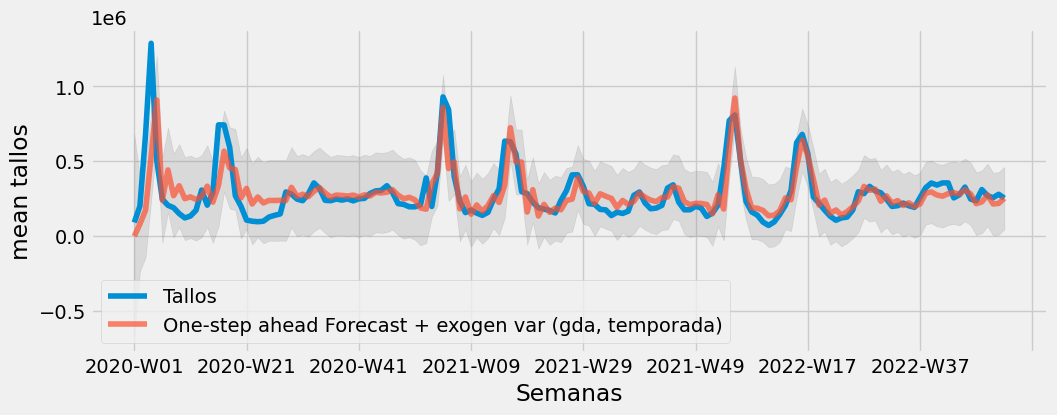

In [124]:
#ax = y['202101':].plot(label='observed') #datos desde 202001
ax =y.loc['2020-W01':'2022-W53'].plot(label='datos originales') #datos desde 202001

pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast + exogen var (gda, temporada)', alpha=.7)
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='gray', alpha=.2)

ax.set_xlabel('Semanas')
ax.set_ylabel('mean tallos')
plt.legend()
plt.show()

In [89]:
pred.predicted_mean# pronosticos para un paso con datos del 2020

Semana
2020-W01         0.000000
2020-W02     81396.126261
2020-W03    173151.748383
2020-W04    534012.508751
2020-W05    909882.596697
                ...      
2022-W48    229419.997872
2022-W49    275567.859681
2022-W50    215158.344993
2022-W51    219321.605624
2022-W52    253764.695085
Name: predicted_mean, Length: 156, dtype: float64

In [90]:
 y_forecasted=pred.predicted_mean

In [91]:
y_truth = y['2022-W02':]

In [92]:
y_forecasted=y_forecasted['2022-W02':]

In [93]:
y_forecasted

Semana
2022-W02    181539.013866
2022-W03    599854.134962
2022-W04    923169.838242
2022-W05    512189.747133
2022-W06    316648.649910
2022-W07    189116.291587
2022-W08    187170.042537
2022-W09    172441.189751
2022-W10    136897.474278
2022-W11    140818.111441
2022-W12    170201.518069
2022-W13    255438.947913
2022-W14    243394.987177
2022-W15    465708.509412
2022-W16    642692.954435
2022-W17    535627.150517
2022-W18    378090.209305
2022-W19    207928.123552
2022-W20    241412.466716
2022-W21    153202.393616
2022-W22    175311.868435
2022-W23    141437.844485
2022-W24    164154.361244
2022-W25    196395.400664
2022-W26    235738.097271
2022-W27    332443.293437
2022-W28    306439.185917
2022-W29    314420.153190
2022-W30    233589.439869
2022-W31    269810.983526
2022-W32    221381.065063
2022-W33    237944.936240
2022-W34    205259.071108
2022-W35    223488.569505
2022-W36    197660.077329
2022-W37    216101.938563
2022-W38    287396.633400
2022-W39    295796.693035
2022-

In [95]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error
score = r2_score(y_truth, y_forecasted)
mape = mean_absolute_percentage_error(y_truth, y_forecasted)

In [96]:
print('R2 {}'.format(round(score, 8)))
print('Mape is {}'.format(round(mape, 10))) #distancia

R2 0.81188006
Mape is 0.2091798133


indicadores con dos variables exogenas
R2 0.65956055
Mape is 0.2344100214
 indicadores con una variable exogena

 R2 0.65957852
Mape is 0.2343573942

R2 0.69532066
Mape is 0.2389518585

R2 0.81188006
Mape is 0.2091798133

In [114]:
# hacer pronósticos dinámicos
#start_date = '2022-01-01'
start_week = '2022-W01' #arranca el pronostico en esta semana
end_w= '2022-W52'
dynamic_periods = 10
pred_dynamic = results.get_prediction(start=start_week, end= end_w, dynamic=True, dynamic_periods=dynamic_periods,  exog_vars_1='2022-W01',full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

#pred = results.get_prediction(start_week='2021-W01', exog_vars_1='2021-W01')

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic_periods', 'exog_vars_1', 'full_results']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


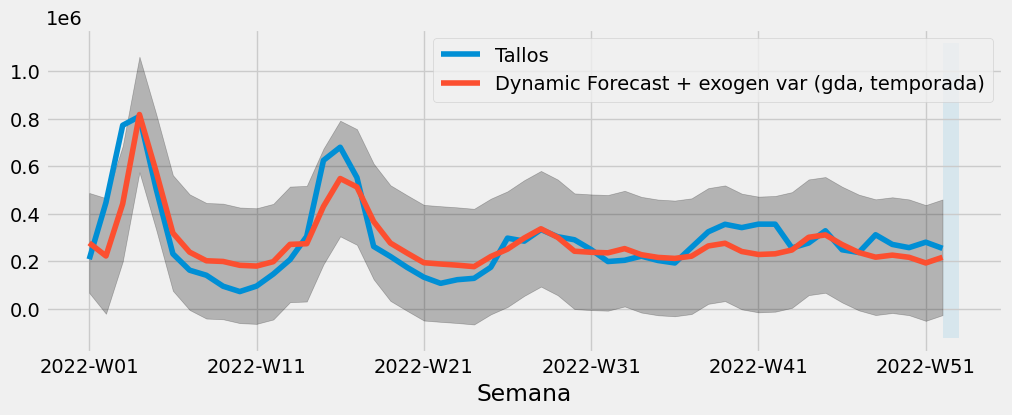

In [123]:
#ax =df_recepcion_prueba.loc['2021-W01':'2022-W52'].plot(label='datos originales') #datos desde 202001
ax =y.loc['2022-W01':'2022-W52'].plot(label='datos originales') #datos desde 202001

pred_dynamic.predicted_mean.plot(label='Dynamic Forecast + exogen var (gda, temporada)', ax=ax)
#start_week = '2020-W01'
#end_week = y.index.max().strftime('%Y-W%U')


ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)



ax.fill_betweenx(ax.get_ylim(), '2021-W01', y.index[-1], alpha=.1, zorder=-1)


#ax.set_xlabel('Semanas')
#ax.set_ylabel('tallos')

plt.legend()
plt.show()

In [116]:
# Extract the predicted and true values of our time series
y_forecasted = pred_dynamic.predicted_mean

In [117]:
y_forecasted

Semana
2022-W01    277033.719693
2022-W02    222066.198145
2022-W03    442187.343687
2022-W04    818125.841999
2022-W05    576662.563465
2022-W06    318823.358846
2022-W07    238171.425938
2022-W08    201891.018566
2022-W09    198957.481743
2022-W10    182701.626606
2022-W11    179513.116944
2022-W12    198027.246465
2022-W13    270910.311137
2022-W14    273737.397843
2022-W15    430584.278487
2022-W16    548359.961769
2022-W17    512727.056717
2022-W18    367228.493610
2022-W19    276459.141051
2022-W20    234278.861180
2022-W21    193694.253583
2022-W22    188200.876004
2022-W23    183286.892277
2022-W24    177119.519102
2022-W25    219690.283513
2022-W26    250799.732237
2022-W27    297702.197737
2022-W28    336665.316395
2022-W29    300345.822497
2022-W30    242069.902355
2022-W31    237636.563262
2022-W32    235278.692854
2022-W33    253031.323588
2022-W34    227387.653828
2022-W35    215948.883846
2022-W36    211801.752165
2022-W37    221167.921770
2022-W38    264189.370528
2022-

In [118]:
y_forecasted=y_forecasted['2021-W01':]

In [119]:
y_forecasted

Semana
2022-W01    277033.719693
2022-W02    222066.198145
2022-W03    442187.343687
2022-W04    818125.841999
2022-W05    576662.563465
2022-W06    318823.358846
2022-W07    238171.425938
2022-W08    201891.018566
2022-W09    198957.481743
2022-W10    182701.626606
2022-W11    179513.116944
2022-W12    198027.246465
2022-W13    270910.311137
2022-W14    273737.397843
2022-W15    430584.278487
2022-W16    548359.961769
2022-W17    512727.056717
2022-W18    367228.493610
2022-W19    276459.141051
2022-W20    234278.861180
2022-W21    193694.253583
2022-W22    188200.876004
2022-W23    183286.892277
2022-W24    177119.519102
2022-W25    219690.283513
2022-W26    250799.732237
2022-W27    297702.197737
2022-W28    336665.316395
2022-W29    300345.822497
2022-W30    242069.902355
2022-W31    237636.563262
2022-W32    235278.692854
2022-W33    253031.323588
2022-W34    227387.653828
2022-W35    215948.883846
2022-W36    211801.752165
2022-W37    221167.921770
2022-W38    264189.370528
2022-

In [120]:
y_truth = y['2022-W01':'2022-W52']

In [121]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error
score = r2_score(y_truth, y_forecasted)
mape = mean_absolute_percentage_error(y_truth, y_forecasted)

In [122]:
print('R2 {}'.format(round(score, 8)))
print('Mape is {}'.format(round(mape, 10))) #distancia

R2 0.69444405
Mape is 0.2864241284


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


<Figure size 2400x1200 with 0 Axes>

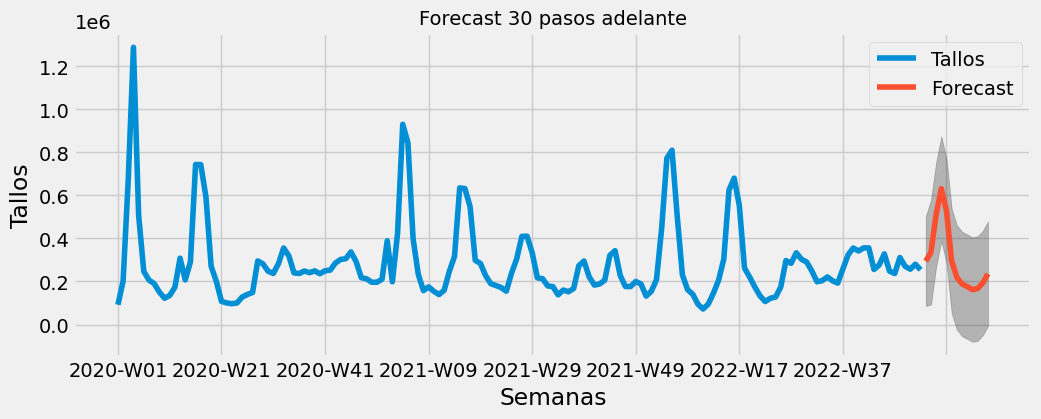

In [143]:
# Get forecast 500 steps ahead in future
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick


# Configurar el formato de las etiquetas del eje X para mostrar solo la semana
week_labels = [idx[-2:] for idx in df_recepcion.index]

# Configurar el tamaño de la figura para evitar la superposición de etiquetas
plt.figure(figsize=(24, 12))


pred_uc = results.get_forecast(steps=13)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()
#Podemos usar la salida de este código para trazar la serie temporal y los pronósticos de sus valores futuros.

#ax = y.plot(label='observed', figsize=(12, 7))
#df_r
ax =y.plot(label='datos originales') #datos desde 202001
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Semanas')
ax.set_ylabel('Tallos')
plt.title('Forecast 30 pasos adelante', fontsize=14)

plt.legend()

In [144]:
 y_forecasted_pred_uc=pred_uc.predicted_mean

In [146]:
y_forecasted_pred_uc

156    294342.869145
157    335826.678464
158    510970.678380
159    631372.509936
160    528896.917516
161    295372.695248
162    219175.182143
163    188664.589567
164    176255.075513
165    162321.056101
166    167113.327472
167    192594.935751
168    235461.118425
Name: predicted_mean, dtype: float64

In [147]:
y_forecasted_pred_uc.to_csv('ForecastArima_13_Sep_202252_(2_0_3_52.csv',sep= ";", header=True, index=True)